In [1]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
print(pm.__version__)
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm

%matplotlib inline
plt.style.use('bmh')
#plt.rc('text', usetex=True)

3.0.rc4


# Data

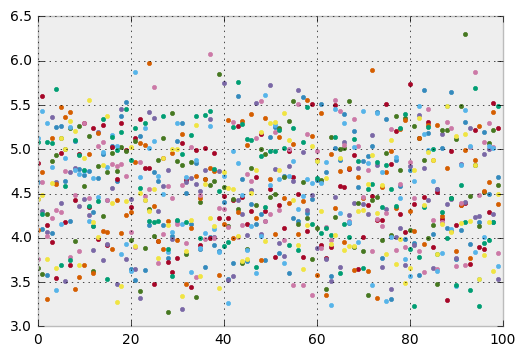

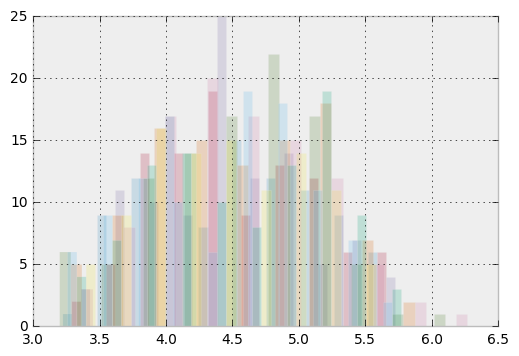

In [2]:
x = np.arange(100)
n = 3
y_mean = .5
y_std = 2
y_scale = y_mean**2/y_std
y_shape = y_std/y_mean
y = np.random.gamma(scale=y_scale, shape=y_shape, size=(len(x),n,n)) + 3 
y = y + np.array([np.random.random(size=(n,n))*2 for i in range(len(x))])
for i in range(n):
    plt.plot(x, y[:,:,i], '.')
plt.figure()
bins = 10
for i in range(n):
    _ = plt.hist(y[:,:,i], bins=bins, alpha=.2)

# Model

In [3]:
last=False
def timing(reset=False):
    from datetime import datetime
    global last
    global startt
    if reset or not last:
        last = datetime.now()
        startt = datetime.now()
    else:
        duration = datetime.now() - last
        print('last:',duration.total_seconds(),'s')
        print('total:',(datetime.now() - startt).total_seconds(),'s')
        last = datetime.now()

In [4]:
# using old data and simpler model
def update_model(alpha_mean, alpha_std, beta_mean, beta_std, y):
    with pm.Model() as model:
        timing(True)
        alpha = pm.Normal('alpha', mu=alpha_mean, sd=alpha_std, shape=(n,n))
        print("defined alpha vars")
        timing()

        beta = pm.Normal('beta', mu=beta_mean, sd=beta_std, shape=(n,n))
        print("defined beta vars")
        timing()

        Y = pm.Normal('Y', mu=alpha, sd=beta, observed=y)
        print("defined Y")
        timing()

        start = pm.find_MAP()    
        print("found start")
        timing()

        step = pm.NUTS()
        print("set NUTS")
        timing()

        trace = pm.sample(500, step, start=start, progressbar=True)
        timing()
        
        return trace
        
trace = update_model(np.ones([n,n])*2, 
             np.ones([n,n]), 
             np.ones([n,n])*.1, 
             np.ones([n,n]),
             y)

defined alpha vars
last: 8.345788 s
total: 8.347136 s
defined beta vars
last: 0.018674 s
total: 8.36686 s
defined Y
last: 0.140278 s
total: 8.508054 s


/usr/lib/python3.5/site-packages/pymc3/distributions/continuous.py:60: UserWarning: The variable specified for sd has negative support for Normal, likely making it unsuitable for this parameter.
  warnings.warn(msg)


         Current function value: 7282.027377
         Iterations: 7
         Function evaluations: 63
         Gradient evaluations: 46
found start
last: 3.60452 s
total: 12.113876 s


  0%|          | 0/500 [00:00<?, ?it/s]

set NUTS
last: 10.06642 s
total: 22.181757 s


100%|██████████| 500/500 [00:09<00:00, 54.61it/s] 

last: 9.157674 s
total: 31.339903 s


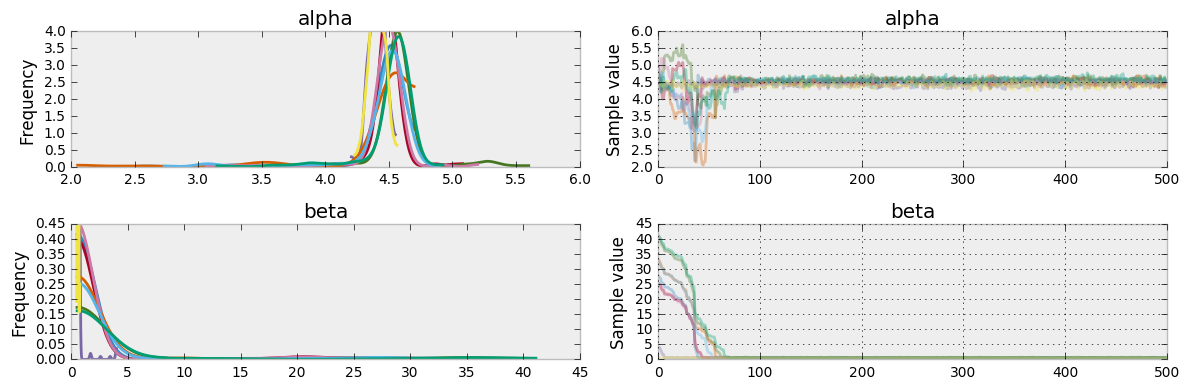

In [5]:
_ = pm.traceplot(trace,
                 varnames=['alpha',
                           'beta'])

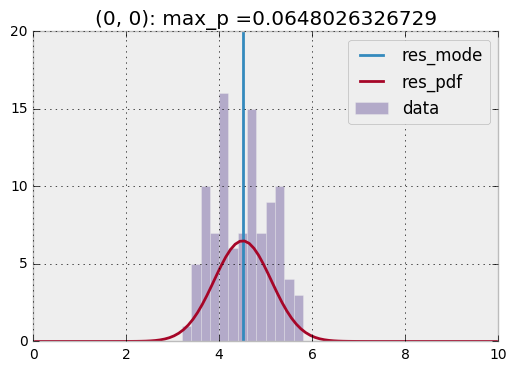

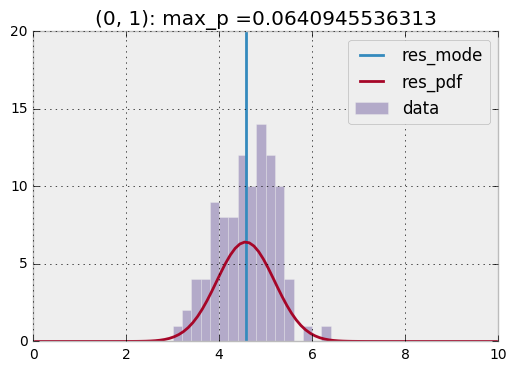

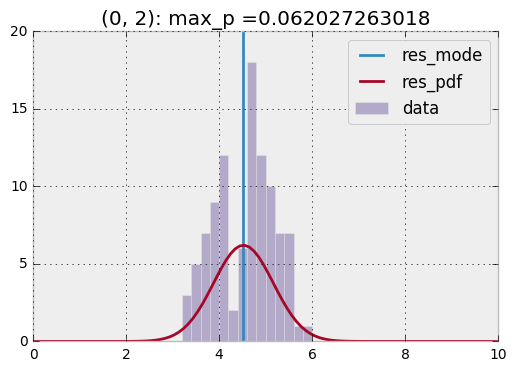

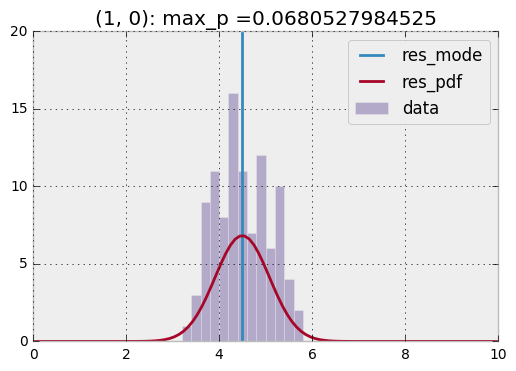

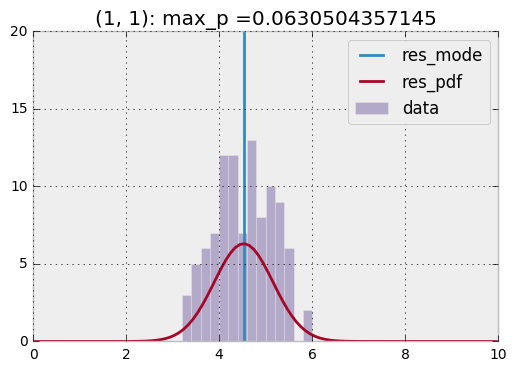

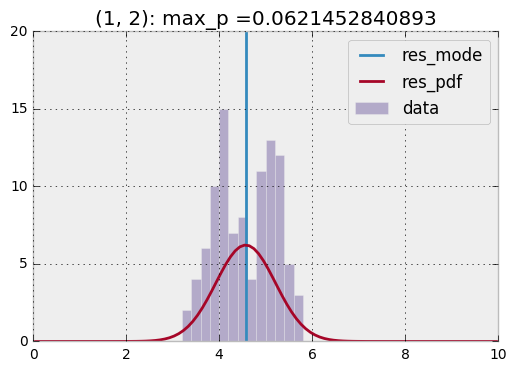

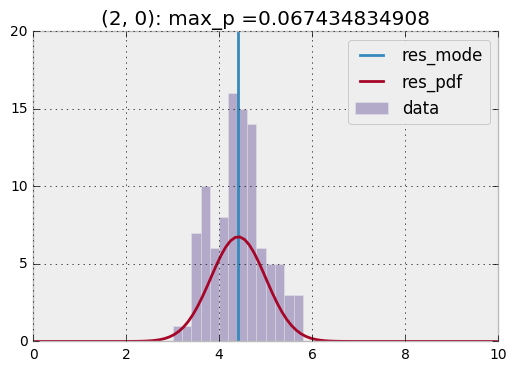

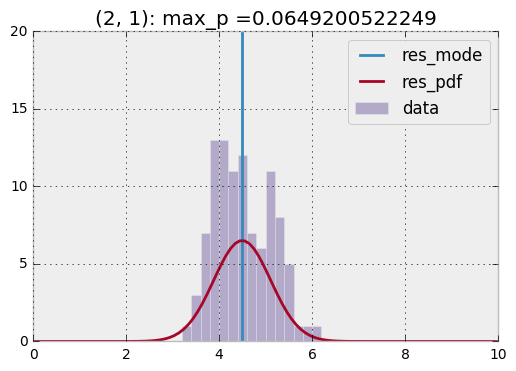

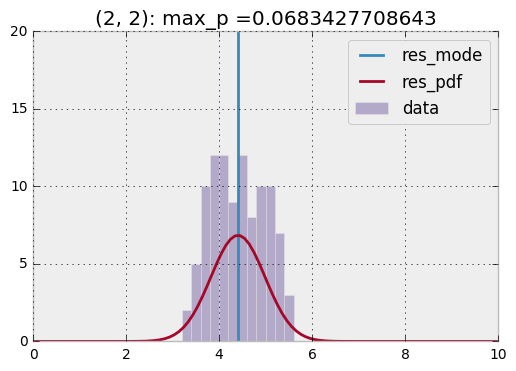

In [6]:
import matplotlib.mlab as mlab
import itertools

def plot_model(trace, burnin_factor):
    alpha_trace = trace.get_values('alpha')
    beta_trace = trace.get_values('beta')

    burnin = int(burnin_factor*len(alpha_trace))

    alpha_mean = np.mean(alpha_trace[burnin:,:,:], axis = 0)
    alpha_std = np.std(alpha_trace[burnin:,:,:], axis = 0)
    assert np.shape(alpha_mean) == (n, n), "Wrong Dimensions"

    beta_mean = np.mean(beta_trace[burnin:,:,:], axis = 0)
    beta_std = np.std(beta_trace[burnin:,:,:], axis = 0)

    mode = alpha_mean

    bins = 50
    maxx = 10
    pdf_resolution = 100

    x = np.linspace(0, maxx, pdf_resolution)

    for i, j in itertools.product(range(n), repeat=2):
        plt.figure()
        m = np.mean(mode[i,j])
        plt.plot([m,m], [20,0])
        res = scipy.stats.norm.pdf(x=x,  
                                   loc=np.mean(alpha_mean[i,j]),
                                   scale=np.mean(beta_mean[i,j]))
        res = res / pdf_resolution * maxx #  seems to be necessary to get true probabilities
        assert np.sum(res)-1 < 1e-6, "The PDF does not sum to one"
        plt.plot(x, res*100)  

        plt.hist(y[:,i,j], bins=bins, range=[0, maxx], alpha=.5)

        plt.legend(["res_mode", 'res_pdf', 'data'])
        plt.title('('+
                  str(i)+
                  ", "+
                  str(j)+
                  '): '+
                  'max_p ='+
                  str(np.max(res)))
    return alpha_mean, alpha_std*2, beta_mean, beta_std*2
        
alpha_mean, alpha_std, beta_mean, beta_std = plot_model(trace, .2)

# altering data ...

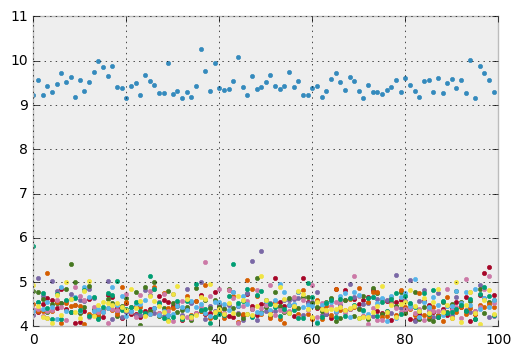

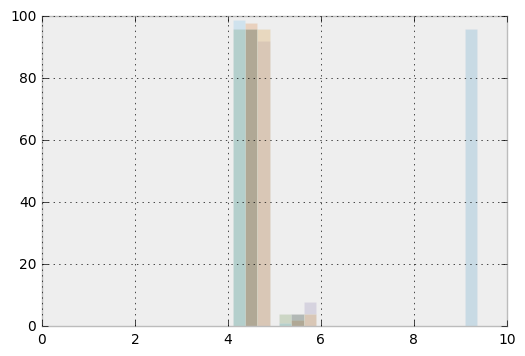

In [7]:
y = np.random.gamma(scale=y_scale, shape=y_shape, size=(len(x),n,n)) + 4
y[:,0,0] = y[:,0,0] + 5
for i in range(n):
    plt.plot(x, y[:,:,i], '.')
plt.figure()
bins = 10
for i in range(n):
    _ = plt.hist(y[:,:,i], bins=bins, alpha=.2, range=[0,10])

In [8]:
# using new data and simpler model
trace = update_model(alpha_mean, alpha_std, beta_mean, beta_std, np.concatenate([y,y])

SyntaxError: unexpected EOF while parsing (<ipython-input-8-cd00c950dd87>, line 2)

In [ ]:
_ = pm.traceplot(trace, 
                 varnames=['alpha',
                           'beta'])

In [ ]:
alpha_mean, alpha_std, beta_mean, beta_std = plot_model(trace, .2)

*Above plot shows the model having trouble adopting to new data fast, which is maybe intended. This can be altered to the multiplyer added to stds of params in **plot_model** method.*
Below you can see that this multplyer (2) seems to work well at this example and allows th emodel to adopt after second update.

In [ ]:
#trace = update_model(alpha_mean, alpha_std, beta_mean, beta_std, y)
#alpha_mean, alpha_std, beta_mean, beta_std = plot_model(trace, .2)